Here are several function that may help to create imbalanced dataset with your weights for each class.

In [1]:
import random

import torch
import torchvision

from matplotlib import pyplot as plt

import numpy as np

In [2]:
BATCH_SIZE = 4

### Download data

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize( (0.1307,), (0.3081,))
])
train_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST('data', train=False, download=True)

len(train_data), len(test_data)

(60000, 10000)

### Create Dataset & DataLoader

In [4]:
# These function will help to find weights for elements of dataset according to distribution of train dataset we need

def get_indices_by_labels(dataset, n_classes):
    indices = [[] for i in range(n_classes)]
    i = 0
    for img, label in dataset:
        indices[label].append(i)
        i += 1
    return indices

def apply_weighted_sampler(dataset, weights):
    elements_weights = [0] * len(dataset)
    indices = get_indices_by_labels(dataset, len(weights))
    
    mult = float(weights[0] / len(indices[0]))
    for i in range(len(weights)):
        mult = max(mult, float(weights[i] / len(indices[i])))
        
    weights = np.array(weights) / mult
    
    for i in range(len(indices)):
        indices[i] = random.sample(indices[i], int(weights[i]))
        for ind in indices[i]:
            elements_weights[ind] = 1
    return np.array(elements_weights)

In [5]:
class_weights = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
weights = apply_weighted_sampler(train_data, class_weights)

In [6]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, int(sum(weights)))   
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)

len(train_loader) * BATCH_SIZE

32716

tensor([7, 5, 8, 4])


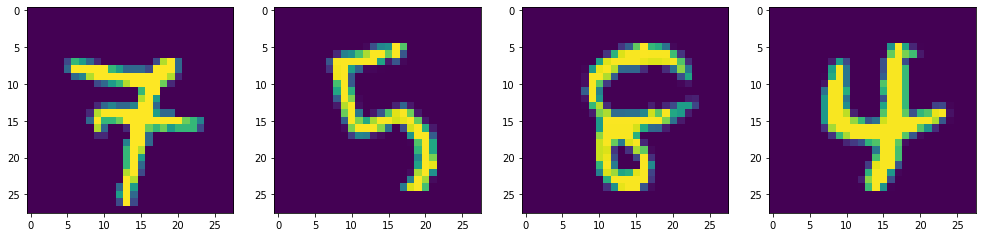

In [7]:
for img, label in train_loader:
    plt.figure(figsize=(17, 8))
    for i in range(len(img)):
        plt.subplot(1, len(img), i + 1)
        plt.imshow(img[i][0])
    print(label)
    break


### Check if it works

In [8]:
freqs = [0] * 10
for img, label in train_loader:
    for l in label:
        freqs[l] += 1

In [9]:
np.array(freqs) / (freqs[0] / class_weights[0])

array([ 1.        ,  1.97840532,  2.99833887,  3.82225914,  4.81395349,
        5.9269103 ,  6.89202658,  7.99667774,  8.91362126, 10.00166113])